In [1]:
# 오호 드디어 coding start! 
# 이제부터 Brandi의 단아한 개발자, 저를 따라오시면 됩니다 :)
# 노트북 Block을 실행하는 방법은 Shift + Enter 입니다

### 기본 셋팅

In [2]:
from sagemaker import get_execution_role

role = get_execution_role()  # 초기에 설정해 뒀던 IAM role 가져오기
bucket = 'sagemaker-julie-test'  # 초기 단계에 만들었던 S3 Bucket 이름 적기

### MNIST 다운로드 받기

In [3]:
%%time
import pickle, gzip, numpy, urllib.request, json

# 여기서 잠깐, 생소한 라이브러리 설명을 드릴게요!
# pickle: python식 데이터 압축 포맷
# numpy: 수치 계산을 하기 위한 python package

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 912 ms, sys: 248 ms, total: 1.16 s
Wall time: 2.11 s


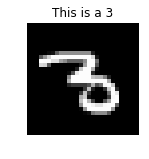

In [4]:
# matplotlib로 그리는 그림이 jupyter 노트북에 바로 보여줄 수 있도록 설정
%matplotlib inline
import matplotlib.pyplot as plt  # 도표나 그림을 그릴 수 있게 해주는 라이브러리
plt.rcParams["figure.figsize"] = (2, 10)  # 그림의 크기 지정

def show_digit(img, caption='', subplot=None):
    if subplot is None:
        _,(subplot) = plt.subplots(1,1)
    
    imgr = img.reshape((28, 28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

# train_set의 그림과[0] 데이터 이름[1]을 예시로 보여준다
show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### 학습(Train)

In [5]:
# 학습을 하기 위해 학습 알고리즘 및 데이터 경로 설정!
from sagemaker import KMeans 

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,  # 장비 2대를 사용하여 학습하겠어요!
                train_instance_type='ml.c4.8xlarge',  
                output_path=output_location,  
                k=10,  # 아래 그림을 참고해 주세요!
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-julie-test/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-julie-test/kmeans_example/output


In [6]:
%%time

# 학습 시작!
kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-05-12-08-27-23-908


........................................
Docker entrypoint called with argument(s): train
[05/12/2018 08:30:41 INFO 139974434043712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[05/12/2018 08:30:41 INFO 139974434043712] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'5000', u'k': u'10', u'force_dense': u'True'}
[05/12/2018 08:30:41 INFO 139

===== Job Complete =====
Billable seconds: 209
CPU times: user 7.62 s, sys: 468 ms, total: 8.09 s
Wall time: 4min 18s


In [7]:
%%time

# 모델을 만든 후 사용하기 위하여 배포하기
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-05-12-08-52-37-371
INFO:sagemaker:Creating endpoint with name kmeans-2018-05-12-08-27-23-908


----------------------------------------------------------------!CPU times: user 264 ms, sys: 4 ms, total: 268 ms
Wall time: 5min 24s


### 모델 테스트 해보기

In [9]:
# valid_set에 30번째 sample을 테스트 해보기

result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.84984016418457
    }
  }
}
]


In [10]:
%%time

# vaild_set에 있는 0번부터 99번까지의 데이터로 cluster를 예측 해보자
result = kmeans_predictor.predict(valid_set[0][0:100])

# 예측 결과에 대한 cluster 정보를 수집
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 335 ms





Cluster 0:


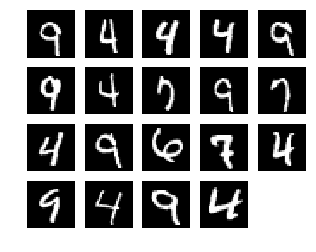




Cluster 1:


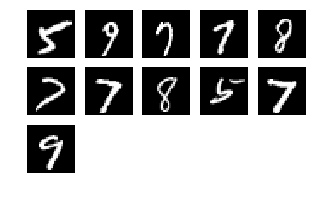




Cluster 2:


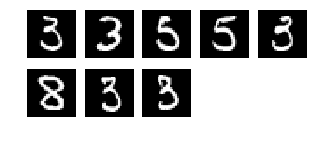




Cluster 3:


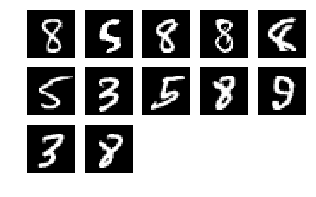




Cluster 4:


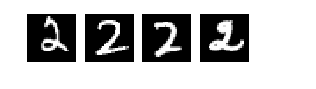




Cluster 5:


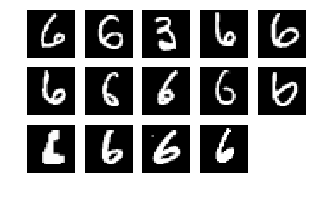




Cluster 6:


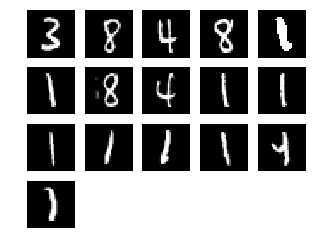




Cluster 7:


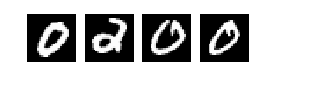




Cluster 8:


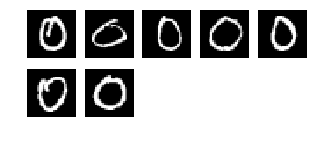




Cluster 9:


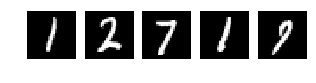

In [12]:
# 각 cluster별 예측된 이미지 출력
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5)+1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
    
    plt.show()